# RAVIR Challenge pipeline

In [1]:
# External modules
import sys
import tensorflow as tf
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Local modules
sys.path.append("/tf/ravir-challenge/") # Root path, change accordingly
from utils import *
from model import *

In [2]:
# Combination of tweaks which aims to prevent death of kernel
tf.compat.v1.disable_eager_execution()
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

# Surpresses warning messages which can be safely ignored
warnings.simplefilter(action = 'ignore', category = UserWarning)

In [3]:
# Hyperparameters

# Data
train_dir = '/tf/ravir-challenge/dataset/train'
test_dir = '/tf/ravir-challenge/dataset/test'
img_w, img_h, img_c = 768, 768, 1
val_ratio = 0.2

# Model
base = 8
batch_normalization = True
dropout_layers = True
dropout_rate = 0.2
optimizer = Adam # Throws errors when there are more than 1 class, change?
n_classes = 1 # Should be 2, as we have artery+vein, background does not count
learning_rate = 1e-4
loss_func = weighted_loss
weight_strength = 1
metric = [dice_coef]
batch_size = 8
epochs = 5

In [4]:
# Read data
image_list = get_file_list(train_dir, 'training_images')
mask_list = get_file_list(train_dir, 'training_masks')


Unique values of image :
 [  0   1   2   3   5  11  13  14  15  16  17  18  19  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246

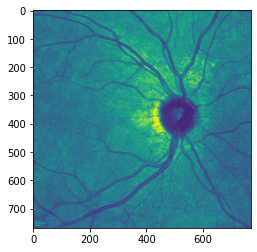

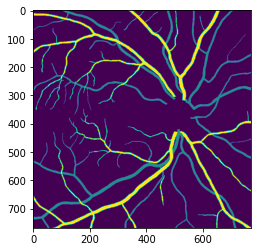

In [5]:
# Display image information for debugging
%matplotlib inline
get_image_information(image_list, img_w, img_h, 'image', loaded = False)
get_image_information(mask_list, img_w, img_h, 'mask', loaded = False)

In [6]:
# Load train data and extract weight maps from masks
train_image_list, train_mask_list, val_image_list, val_mask_list \
= get_train_val_lists(image_list, mask_list, val_ratio)

x_train = load_image(train_image_list, img_w, img_h)
y_train = load_image(train_mask_list, img_w, img_h)
w_train = extract_weight_maps(train_mask_list, img_w, img_h)

x_val = load_image(val_image_list, img_w, img_h)
y_val = load_image(val_mask_list, img_w, img_h)
w_val = extract_weight_maps(val_mask_list, img_w, img_h)


Unique values of image :
 [0.102  0.1059 0.1098 0.1137 0.1177 0.1216 0.1255 0.1294 0.1333 0.1372
 0.1412 0.1451 0.149  0.153  0.1569 0.1608 0.1647 0.1686 0.1726 0.1765
 0.1804 0.1843 0.1882 0.1921 0.196  0.2    0.204  0.2079 0.2118 0.2157
 0.2196 0.2235 0.2274 0.2313 0.2354 0.2393 0.2432 0.2471 0.251  0.255
 0.2588 0.2627 0.2666 0.2705 0.2744 0.2783 0.2825 0.2864 0.2903 0.2942
 0.298  0.302  0.306  0.3098 0.3137 0.3176 0.3215 0.3254 0.3293 0.3333
 0.3372 0.341  0.3452 0.349  0.353  0.357  0.3608 0.3647 0.3687 0.3726
 0.3765 0.3804 0.3843 0.3882 0.392  0.396  0.4    0.4038 0.408  0.4119
 0.4158 0.4197 0.4236 0.4275 0.4314 0.4353 0.4392 0.443  0.447  0.451
 0.4548 0.4587 0.4626 0.4666 0.4707 0.4746 0.4785 0.4824 0.4863 0.4902
 0.4941 0.498  0.502  0.506  0.51   0.5137 0.5176 0.5215 0.5254 0.5293
 0.533  0.537  0.541  0.545  0.549  0.5527 0.5566 0.5605 0.565  0.569
 0.5728 0.5767 0.5806 0.5845 0.5884 0.5923 0.596  0.6    0.604  0.608
 0.612  0.6157 0.6196 0.6235 0.6274 0.6313 0.6353 0.63

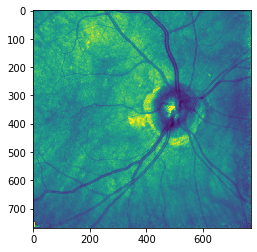


Unique values of mask :
 [0.    0.502 1.   ]


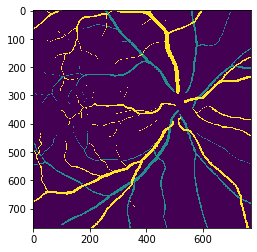


Unique values of weight map :
 [0.    0.498 0.502 1.   ]


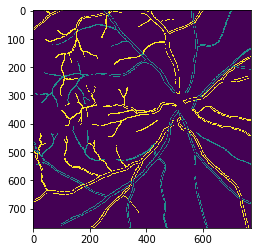

In [7]:
# Display image information for debugging
%matplotlib inline
get_image_information(x_train, img_w, img_h, 'image', loaded = True)
get_image_information(y_train, img_w, img_h, 'mask', loaded = True)
get_image_information(w_train, img_w, img_h, 'weight map', loaded = True)

In [8]:
#Compile model
weight_map = Input(shape=(img_w, img_h, img_c), name='weight_map')
inputs_layer = Input(shape=(img_w, img_h, img_c), name='input_layer')
weighted_input = (inputs_layer, weight_map)

model = get_weighted_unet(weighted_input, 
                          base,
                          batch_normalization, 
                          dropout_layers, dropout_rate,
                          img_w, img_h, img_c,
                          n_classes)

model.compile(optimizer = optimizer(learning_rate),
              loss = loss_func(weight_map, weight_strength),
              metrics = metric)

Instructions for updating:
Colocations handled automatically by placer.
Model: "Weighted UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 768, 768, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 768, 768, 8)  80          ['input_layer[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 768, 768, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
              

 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 96, 96, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 48, 48, 64)  0           ['activation_7[0][0]']           
                                                                                                  
 dropout_3 (Dropout)            (None, 48, 48, 64)   0           ['max_pooling2d_3[0][0]']        
                                                                                                  
 conv2d_8 (Conv2D)              (None, 48, 48, 128)  73856       ['dropout_3[0][0]']              
                                                                                                  
 batch_nor

 batch_normalization_14 (BatchN  (None, 384, 384, 16  64         ['conv2d_14[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_14 (Activation)     (None, 384, 384, 16  0           ['batch_normalization_14[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 384, 384, 16  2320        ['activation_14[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 384, 384, 16  64         ['conv2d_15[0][0]']              
 ormalizat

In [9]:
#Fit model
train_generator = generator_with_weights(x_train, y_train, w_train, batch_size)

# Maybe implement callbacks? Would be good for optimization
# https://www.tensorflow.org/guide/keras/train_and_evaluate#using_callbacks

model_history = model.fit(train_generator,
                          steps_per_epoch = x_train.shape[0]//batch_size,
                          epochs = epochs,
                          validation_steps = len(x_val),
                          validation_data = ([x_val, w_val], y_val),
                          shuffle = False,
                          class_weight = 'auto')

Epoch 1/5
2/2 [==============================] - 9s 1s/step - batch: 0.5000 - size: 8.0000 - loss: -0.1403 - dice_coef: 0.2462 - val_loss: -0.0640 - val_dice_coef: 0.0705
Epoch 2/5
2/2 [==============================] - 2s 590ms/step - batch: 0.5000 - size: 5.5000 - loss: -0.1426 - dice_coef: 0.2492 - val_loss: -0.0638 - val_dice_coef: 0.0703
Epoch 3/5
2/2 [==============================] - 1s 512ms/step - batch: 0.5000 - size: 5.5000 - loss: -0.1404 - dice_coef: 0.2461 - val_loss: -0.0653 - val_dice_coef: 0.0719
Epoch 4/5
2/2 [==============================] - 1s 583ms/step - batch: 0.5000 - size: 8.0000 - loss: -0.1433 - dice_coef: 0.2514 - val_loss: -0.0634 - val_dice_coef: 0.0698
Epoch 5/5
2/2 [==============================] - 1s 580ms/step - batch: 0.5000 - size: 5.5000 - loss: -0.1425 - dice_coef: 0.2494 - val_loss: -0.0632 - val_dice_coef: 0.0696


The keys are:  ['loss', 'dice_coef', 'val_loss', 'val_dice_coef']


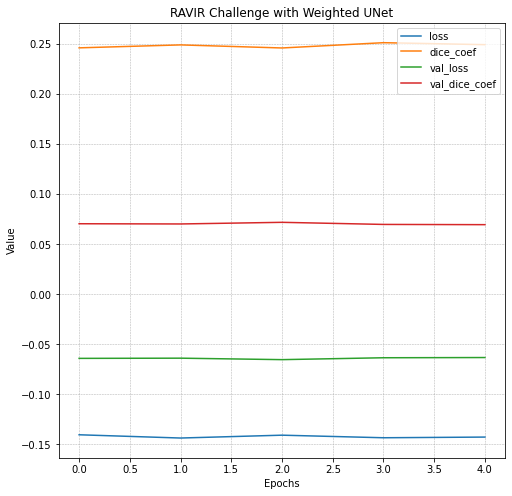

In [10]:
# Plot model history to evaluate performance
%matplotlib inline

# Plot parameters
size_x = 8
size_y = 8
title = 'RAVIR Challenge with Weighted UNet'
x_label = 'Epochs'
y_label = 'Value'
legend = True
print_keys = True

plot_model_history(size_x, size_y, title, x_label, y_label, legend, print_keys, model_history)

In [11]:
# Read and load test images for prediction
test_image_list = get_file_list(test_dir, '')
x_test = load_image(test_image_list, img_w, img_h)


Unique values of image :
 [0.       0.011765 0.0196   0.02745  0.0353   0.04706  0.051    0.05884
 0.06665  0.0706   0.0745   0.0784   0.08234  0.0863   0.0902   0.0941
 0.098    0.102    0.1059   0.1098   0.1137   0.1177   0.1216   0.1255
 0.1294   0.1333   0.1372   0.1412   0.1451   0.149    0.153    0.1569
 0.1608   0.1647   0.1686   0.1726   0.1765   0.1804   0.1843   0.1882
 0.1921   0.196    0.2      0.204    0.2079   0.2118   0.2157   0.2196
 0.2235   0.2274   0.2313   0.2354   0.2393   0.2432   0.2471   0.251
 0.255    0.2588   0.2627   0.2666   0.2705   0.2744   0.2783   0.2825
 0.2864   0.2903   0.2942   0.298    0.302    0.306    0.3098   0.3137
 0.3176   0.3215   0.3254   0.3293   0.3333   0.3372   0.341    0.3452
 0.349    0.353    0.357    0.3608   0.3647   0.3687   0.3726   0.3765
 0.3804   0.3843   0.3882   0.392    0.396    0.4      0.4038   0.408
 0.4119   0.4158   0.4197   0.4236   0.4275   0.4314   0.4353   0.4392
 0.443    0.447    0.451    0.4548   0.4587   0.462

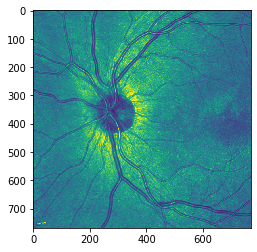

In [12]:
# Display image information for debugging
%matplotlib inline
get_image_information(x_test, img_w, img_h, 'image', loaded = True)

In [13]:
# Predict test images - images https://www.tensorflow.org/tutorials/images/segmentation#train_the_model

# NOTE: Does not work as model.predict() wants the same type of input as during training.
#       It might be due to train_generator or it might be due to the weight-map in Input/loss
#       Can't supply test with a weight-map as it requires a mask (which is the prediction we are looking for).
#       See .predict arguments here: https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict

# Another solution might be to save weights after training and then compile a new model that don't use weight maps.
# Not sure if this is possible however as the weights might be model-dependent.
# https://www.tensorflow.org/tutorials/keras/save_and_load
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#save_weights

# Make a for-loop: "For each image in the list x_test, make a prediction and append the output to another list"
predicted_mask = model.predict(x_test[0])

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), for inputs ['input_layer', 'weight_map'] but instead got the following list of 1 arrays: [array([[[0.2942],
        [0.349 ],
        [0.2864],
        ...,
        [0.2393],
        [0.2235],
        [0.2235]],

       [[0.298 ],
        [0.3215],
        [0.2627],
        ...,
        [...

In [ ]:
# Display a predicted image for debugging, get_image_information might work for this:
# get_image_information(predicted_mask_list, img_w, img_h, 'mask', loaded = True)

In [ ]:
# Save predicted images to folder
# Pixel values are in the range [0, 1], need to have them as: [0, 128, 255]
# Make a for-loop: "For each predicted mask in the list, fix pixel values and save as image"
# cv2.imwrite might be what we are looking for, maybe make a utility that takes a list and saves all images?
# Like so: save_masks(predicted_mask_list, "/tf/ravir-challenge/predictions")